<a href="https://colab.research.google.com/github/tpgus2603/ImageCaptioning/blob/main/imagecaptioning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""ViT_eta_GPT2의 사본

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1e6p_vy8JKTI5Y5IQ2H8_L1Jdf_HPHajj
"""

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
# URL encoded dataset source
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240730%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240730T133455Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D26716cabb1eae092be5b5dda683ae878f04056ba09b10ae175aec8239d3533c9e6ccf5d0835897a609f345fe4d30a47046dafd7960edc53f459bde36ab5bc52f7f29f5a2a1849cab60a2054c9e9324658f26bd81784602c028fad10bf9b99cad31e5e757c8ac0a2326c8e3191618d3361fd1a9208ea2ef9da703327a4ab925d6aacbaf2648ee5c85f0a457ef9b478fb22a586fbc2b2458ee64769ad765a0823662dac5cb368d5523a869ac42147818a847187b211c1e5fb11bc19edf565293105ba78c14037bdbdb7d92b2919361707b61a17c75683d062fcd5d802dcee5aad099cc39f243a621473d6cb719f5bfe5fb1230d18844be0050304b9ee15751bae2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

# Unmount the input path if it exists, and recreate the necessary directories
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Create symlinks for input and working directories
try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

# Download and extract dataset files from the provided URLs
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            # Extract the downloaded file based on its extension
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


In [ ]:
!pip install git+https://github.com/salaniz/pycocoevalcap

from pycocoevalcap.cider.cider import Cider



  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-bqsu9078
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-bqsu9078
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312247 sha256=ef61872c14a791942685da3a338dc21a22df47c3ae6a3b0fb17989fdb54697c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8rc_kzma/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as T
import torchvision.models as models
from transformers import BertTokenizer, BertModel
from pycocoevalcap.cider.cider import Cider
import os
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
import spacy

# 데이터 위치 설정
data_location = "../input/flickr8k"

# 텍스트 데이터 읽기
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
df['caption'] = df['caption'].astype(str).fillna('')  # 결측값 채우기
print("There are {} image to captions".format(len(df)))
df.head(7)

# Spacy로 토큰화
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        # 사전 인덱스와 토큰 매핑
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        # 텍스트를 소문자로 변환하여 토큰화
        tokens = [token.text.lower() for token in spacy_eng.tokenizer(str(text))]
        return tokens

    def build_vocab(self, sentence_list):
        # 주어진 문장 리스트를 사용하여 어휘 사전 구축
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        # 텍스트를 토큰화하여 숫자로 변환
        tokenized_text = self.tokenize(text)
        numericalized = [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]
        return numericalized

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=20):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file, dtype={'image': str, 'caption': str})
        self.df['caption'] = self.df['caption'].fillna('')  # 결측값 채우기
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

    def __getitem__(self, idx):
        # 인덱스로부터 이미지와 캡션을 가져옴
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = [self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]]
        return img, torch.tensor(caption_vec)

    def __len__(self):
        return len(self.df)

class CapsCollate:
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        # 배치 내의 모든 이미지를 하나의 텐서로 결합
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        # 배치 내의 모든 캡션을 하나의 텐서로 결합
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs, targets

def get_data_loader(dataset, vocab, batch_size, shuffle=False, num_workers=1):
    # DataLoader 생성
    pad_idx = vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx, batch_first=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)

# 데이터셋 및 데이터 로더 초기화
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
dataset = FlickrDataset(root_dir=data_location + "/Images", captions_file=caption_file, transform=transforms)

# 데이터셋 분할 (80% 훈련, 20% 테스트)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Vocabulary 객체 생성
vocab = dataset.vocab


There are 40455 image to captions


In [ ]:
train_loader = get_data_loader(train_dataset, vocab, batch_size=128, shuffle=True, num_workers=4)
test_loader = get_data_loader(test_dataset, vocab, batch_size=128, shuffle=False, num_workers=4)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

print("Dataset samples:")
print(df.head())

print("Dataset and DataLoader are successfully initialized.")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Dataset samples:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
Dataset and DataLoader are successfully initialized.


In [ ]:
import torchvision.models as models
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import time
# 이미지 인코더 정의 (ResNet)
class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.dropout(self.fc(features))
        return features

# 텍스트 인코더 정의 (BERT)
class TextEncoder(nn.Module):
    def __init__(self, embed_size):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size, embed_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, captions):
        with torch.no_grad():
            outputs = self.bert(captions)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 임베딩을 사용
        embeddings = self.dropout(self.fc(embeddings))
        return embeddings

# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
import torch.nn.functional as F

class TransformerDecoder(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads, num_layers, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.transformer = nn.Transformer(
            d_model=embed_size, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dropout=dropout
        )
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.embed_size = embed_size

    def forward(self, image_features, text_features, captions):
        tgt = self.embedding(captions).permute(1, 0, 2)
        src = torch.cat((image_features.unsqueeze(1), text_features.unsqueeze(1)), dim=1).permute(1, 0, 2)
        memory = self.transformer.encoder(src)
        output = self.transformer.decoder(tgt, memory)
        output = self.fc_out(output)
        return output.permute(1, 0, 2)

    def generate_caption(self, image_features, text_features, vocab, max_length=50):
        output_caption = []
        input_caption = torch.tensor([vocab.stoi["<SOS>"]]).unsqueeze(0).to(image_features.device)
        image_features = image_features.unsqueeze(0)  # Add batch dimension
        text_features = text_features.unsqueeze(0)    # Add batch dimension

        for i in range(max_length):
            tgt = self.embedding(input_caption).permute(1, 0, 2)
            src = torch.cat((image_features, text_features), dim=1).permute(1, 0, 2)
            memory = self.transformer.encoder(src)
            tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(image_features.device)
            output = self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask)
            output = self.fc_out(output)
            predicted_id = output.argmax(2)[-1, -1].item()

            if predicted_id == vocab.stoi["<EOS>"]:
                break
            output_caption.append(predicted_id)
            input_caption = torch.cat([input_caption, torch.tensor([[predicted_id]]).to(image_features.device)], dim=1)

        return [vocab.itos[idx] for idx in output_caption if idx not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast

Image features shape: torch.Size([16, 256])


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Image features: tensor([-0.0000,  0.3199,  0.0000,  0.0000,  0.0000,  0.6821,  0.0826, -0.1772,
        -0.0000, -0.3152], device='cuda:0', grad_fn=<SliceBackward0>)
Text features shape: torch.Size([16, 256])
Text features: tensor([-0.0000, -1.3121,  0.0000, -0.6494,  1.0300, -0.4206, -1.1725, -0.0000,
         0.4922,  0.3657], device='cuda:0', grad_fn=<SliceBackward0>)


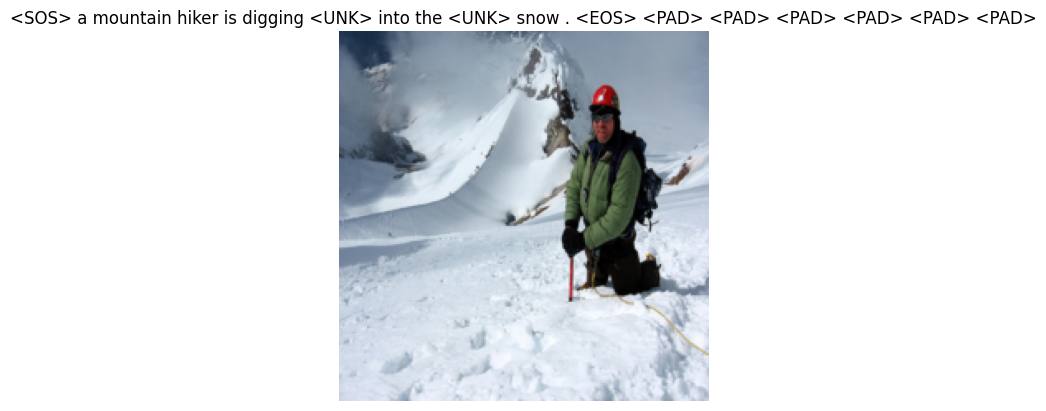

In [ ]:
# import matplotlib.pyplot as plt

# # 이미지 인코더와 텍스트 인코더 디버깅을 위한 함수
# def debug_encoders(image_encoder, text_encoder, data_loader, vocab):
#     dataiter = iter(data_loader)
#     images, captions = next(dataiter)
#     images, captions = images.to(device), captions.to(device)

#     # 이미지 인코더 특징 추출
#     image_features = image_encoder(images)
#     print(f"Image features shape: {image_features.shape}")
#     print(f"Image features: {image_features[0, :10]}")  # 첫 10개 특징만 출력

#     # 텍스트 인코더 특징 추출
#     text_features = text_encoder(captions)
#     print(f"Text features shape: {text_features.shape}")
#     print(f"Text features: {text_features[0, :10]}")  # 첫 10개 특징만 출력

#     # 이미지 시각화
#     plt.imshow(images[0].permute(1, 2, 0).cpu())
#     plt.axis('off')

#     # 캡션 출력
#     caption_text = ' '.join([vocab.itos[idx.item()] for idx in captions[0]])
#     plt.title(caption_text)
#     plt.show()
# # 하이퍼파라미터 설정
# embed_size = 256
# vocab_size = len(vocab)
# num_heads = 8
# num_layers = 6
# learning_rate = 0.0001
# num_epochs = 30
# print_every = 100
# patience = 5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # 모델 초기화
# image_encoder = ImageEncoder(embed_size).to(device)
# text_encoder = TextEncoder(embed_size).to(device)
# decoder = TransformerDecoder(embed_size, vocab_size, num_heads, num_layers).to(device)

# # 손실 함수 및 옵티마이저 설정
# criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
# optimizer = optim.Adam(list(image_encoder.parameters()) + list(text_encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# # 이미지 인코더, 텍스트 인코더, 데이터 로더 확인
# debug_encoders(image_encoder, text_encoder, train_loader, vocab)

In [ ]:
embed_size = 256
vocab_size = len(vocab)
num_heads = 8
num_layers = 6
learning_rate = 0.0005
num_epochs = 30
print_every = 100
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델 초기화
image_encoder = ImageEncoder(embed_size).to(device)
text_encoder = TextEncoder(embed_size).to(device)
decoder = TransformerDecoder(embed_size, vocab_size, num_heads, num_layers).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(list(image_encoder.parameters()) + list(text_encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1, Batch: 100, Loss: 4.383252143859863
Generated caption: .


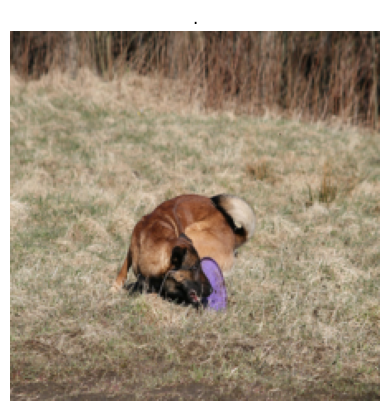

Epoch: 1, Batch: 200, Loss: 4.138751983642578
Generated caption: 


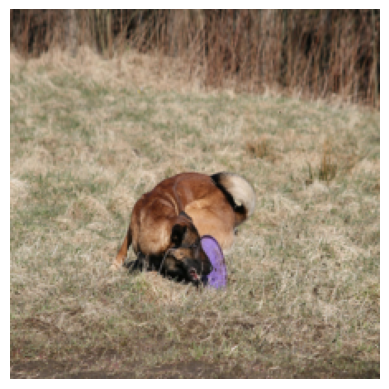

Epoch: 1, Average Training Loss: 4.418234955180775
Validation Loss after epoch 2: 4.031587433069944
Epoch: 1
Epoch 1 duration: 490.19 seconds
Epoch: 2, Batch: 100, Loss: 3.934901237487793
Generated caption: 


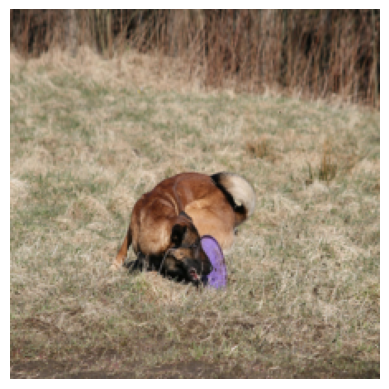

Epoch: 2, Batch: 200, Loss: 3.669786214828491
Generated caption: 


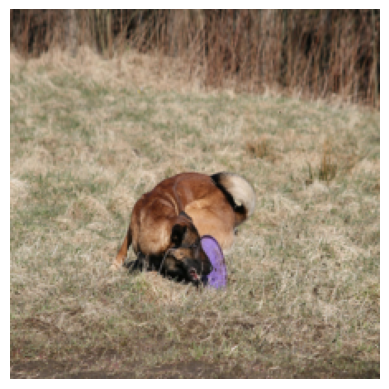

Epoch: 2, Average Training Loss: 3.8647590437425454
Validation Loss after epoch 3: 3.7120300978422165
Epoch: 2
Epoch 2 duration: 495.08 seconds
Epoch: 3, Batch: 100, Loss: 3.6511716842651367
Generated caption: 


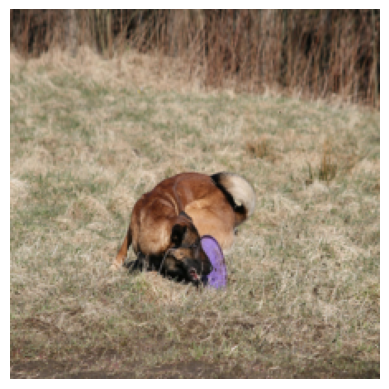

Epoch: 3, Batch: 200, Loss: 3.5554006099700928
Generated caption: <UNK> on <UNK> in <UNK> in <UNK> in <UNK> in shirt in the background in the background in the background in the background in the background in the <UNK> in the <UNK> in the <UNK> in the <UNK> in the <UNK> in the <UNK> in the <UNK> in the <UNK>


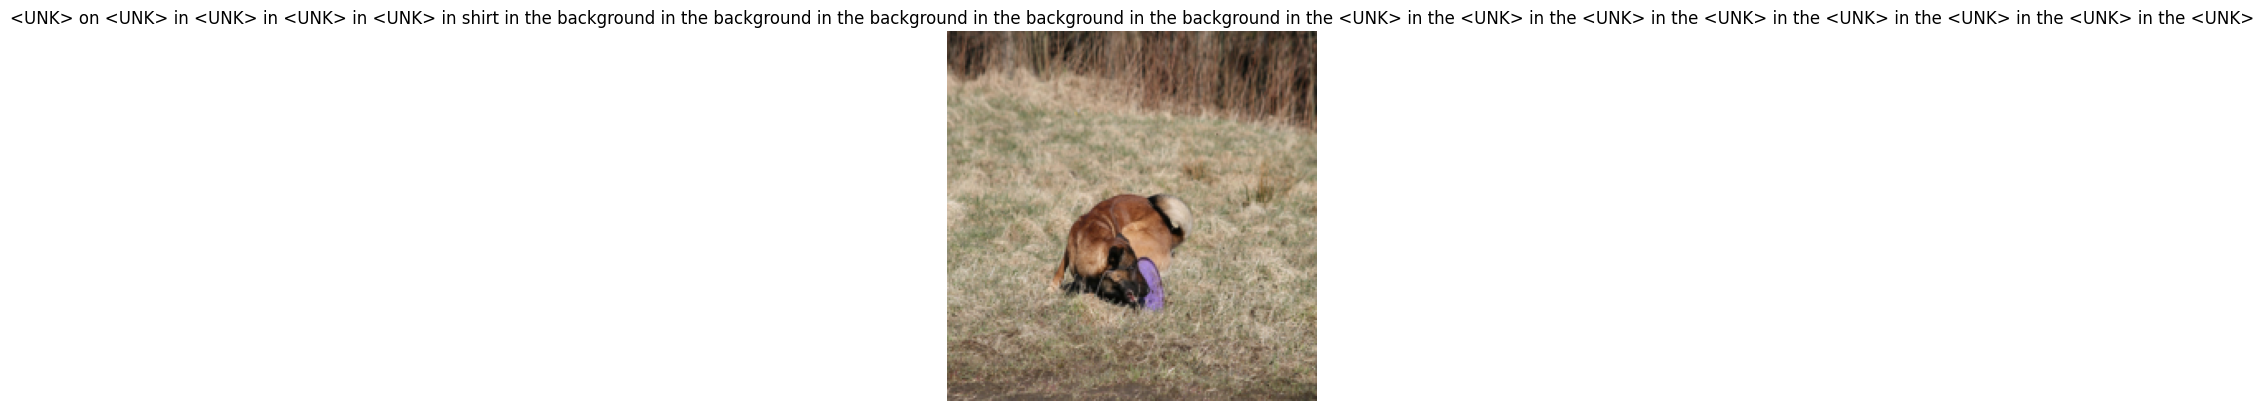

Epoch: 3, Average Training Loss: 3.5700266238729004
Validation Loss after epoch 4: 3.317570097744465
Epoch: 3
Epoch 3 duration: 494.93 seconds
Epoch: 4, Batch: 100, Loss: 3.365753650665283
Generated caption: <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on


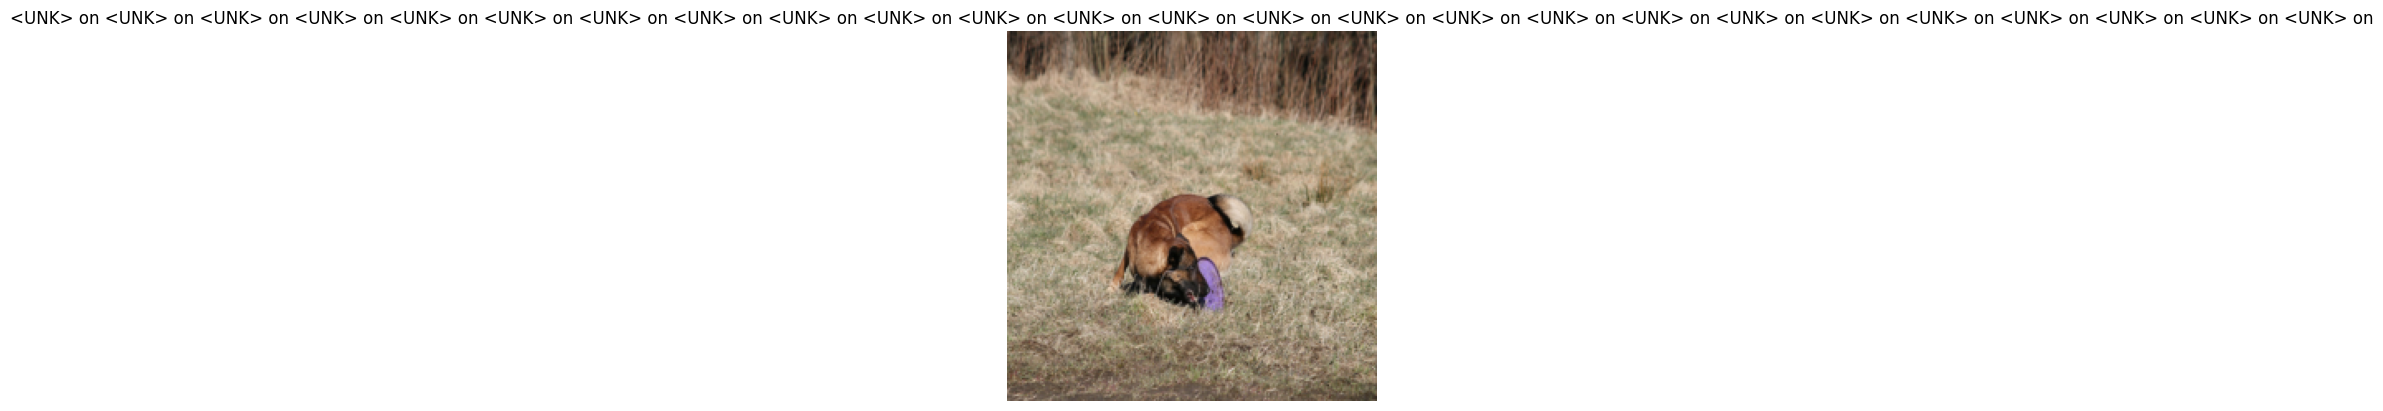

Epoch: 4, Batch: 200, Loss: 3.1543495655059814
Generated caption: <UNK> at <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on


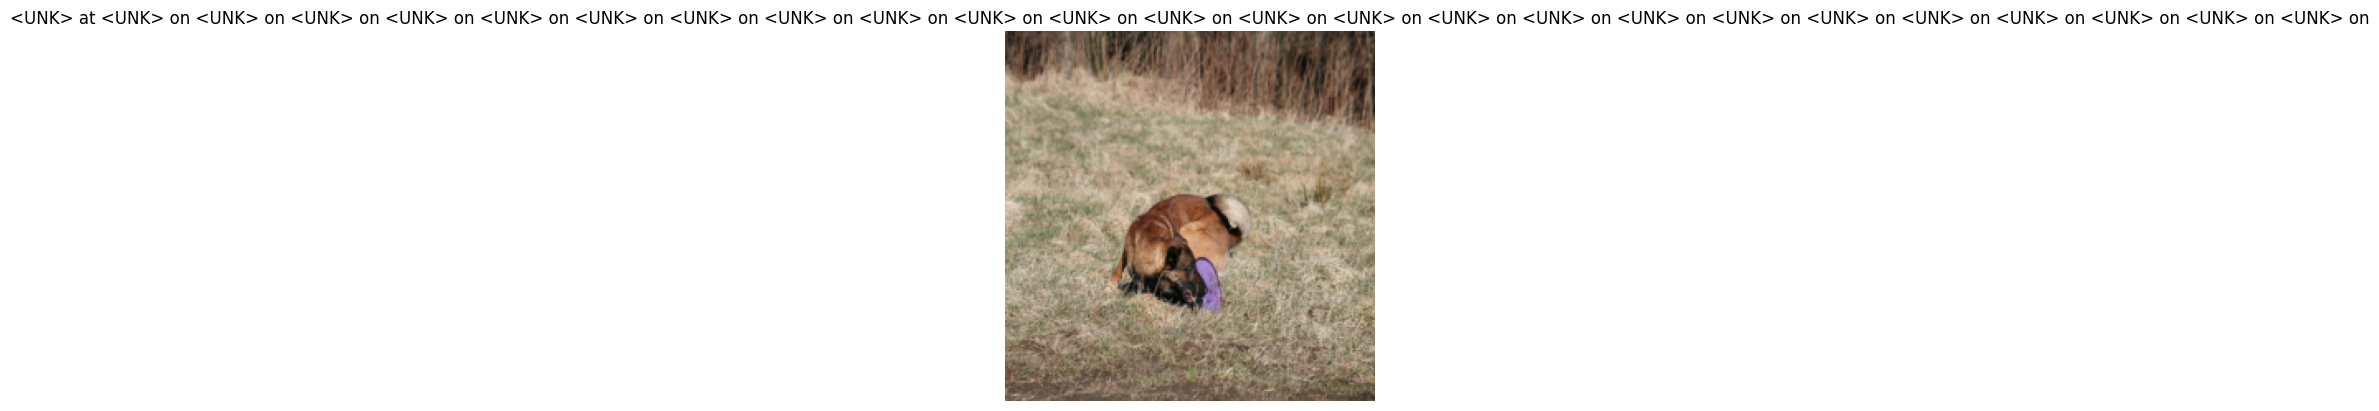

Epoch: 4, Average Training Loss: 3.2920129836312397
Validation Loss after epoch 5: 3.0903636887669563
Epoch: 4
Epoch 4 duration: 494.95 seconds
Epoch: 5, Batch: 100, Loss: 3.0679550170898438
Generated caption: <UNK> on <UNK> at <UNK>


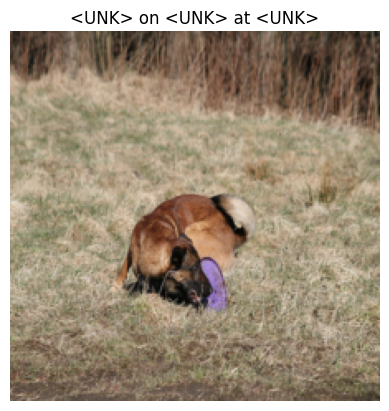

Epoch: 5, Batch: 200, Loss: 2.937703847885132
Generated caption: <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on <UNK> on


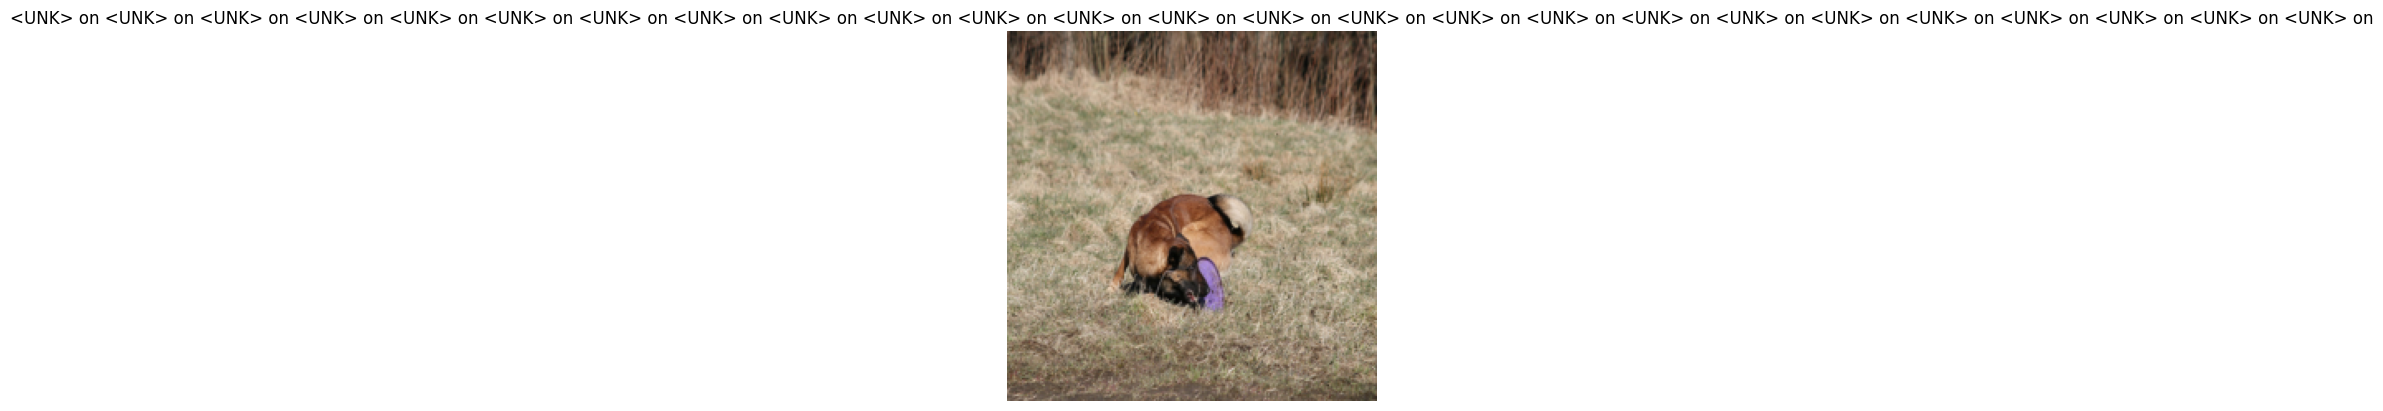

Epoch: 5, Average Training Loss: 3.0712786757427715
Validation Loss after epoch 6: 2.909895684570074
Epoch: 5
Epoch 5 duration: 495.87 seconds
Epoch: 6, Batch: 100, Loss: 2.7902982234954834
Generated caption: on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on


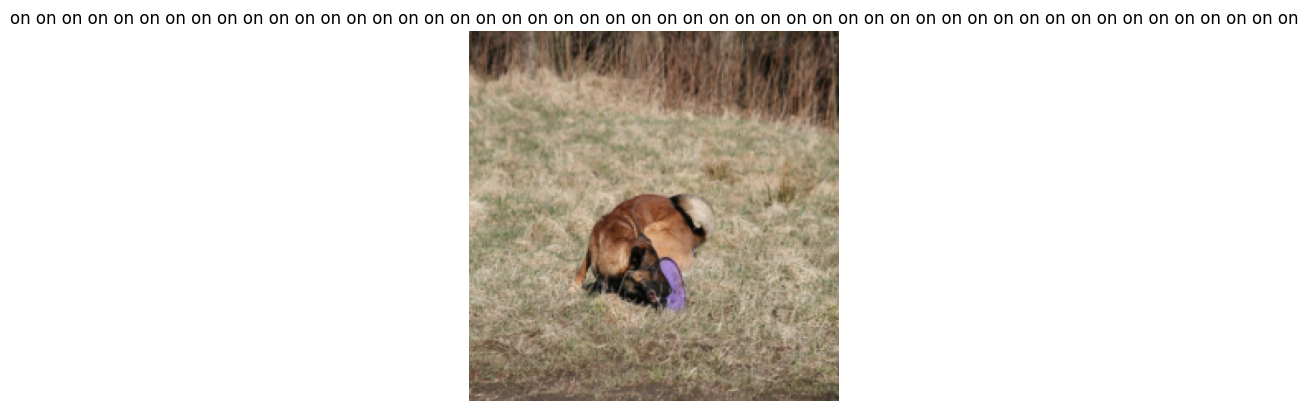

Epoch: 6, Batch: 200, Loss: 2.6557936668395996
Generated caption: 


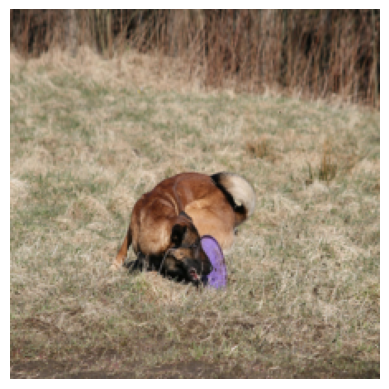

Epoch: 6, Average Training Loss: 2.87586819513042
Validation Loss after epoch 7: 2.8044291771948338
Epoch: 6
Epoch 6 duration: 509.97 seconds
Epoch: 7, Batch: 100, Loss: 2.663769245147705
Generated caption: on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on


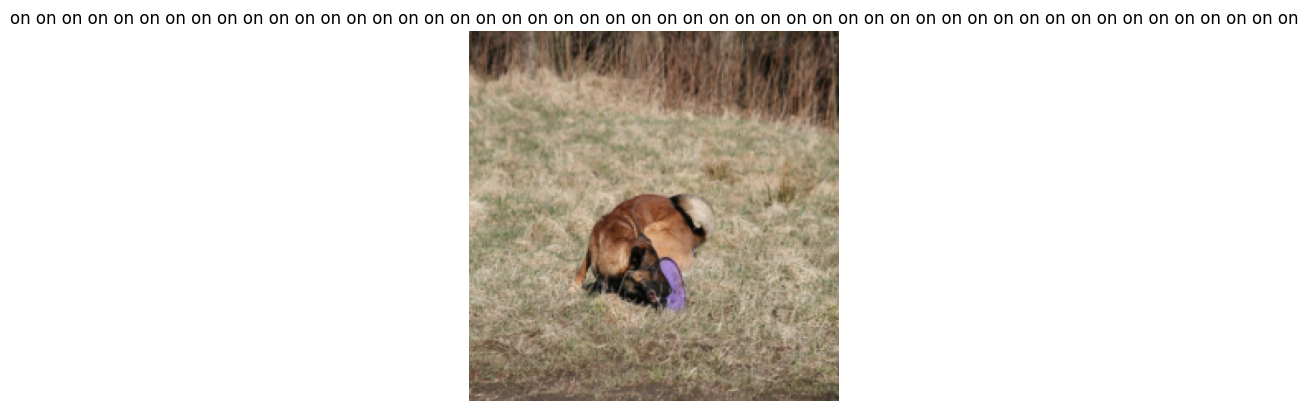

Epoch: 7, Batch: 200, Loss: 2.463984251022339
Generated caption: on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on


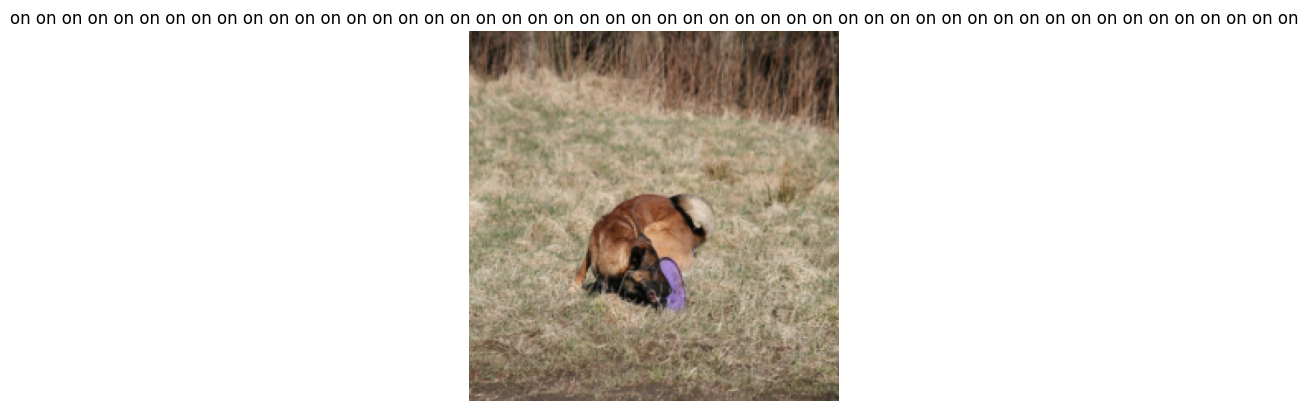

Epoch: 7, Average Training Loss: 2.6434993093663994
Validation Loss after epoch 8: 2.4505420438945293
Epoch: 7
Epoch 7 duration: 487.80 seconds
Epoch: 8, Batch: 100, Loss: 2.338391065597534
Generated caption: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


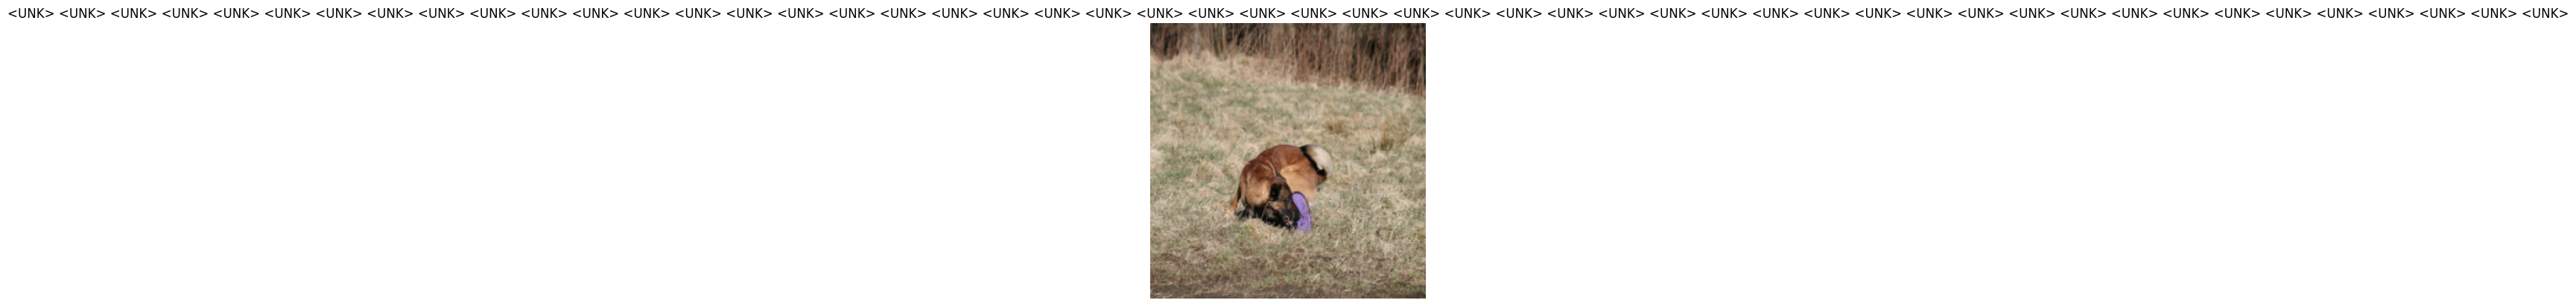

Epoch: 8, Batch: 200, Loss: 2.4280688762664795
Generated caption: on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on


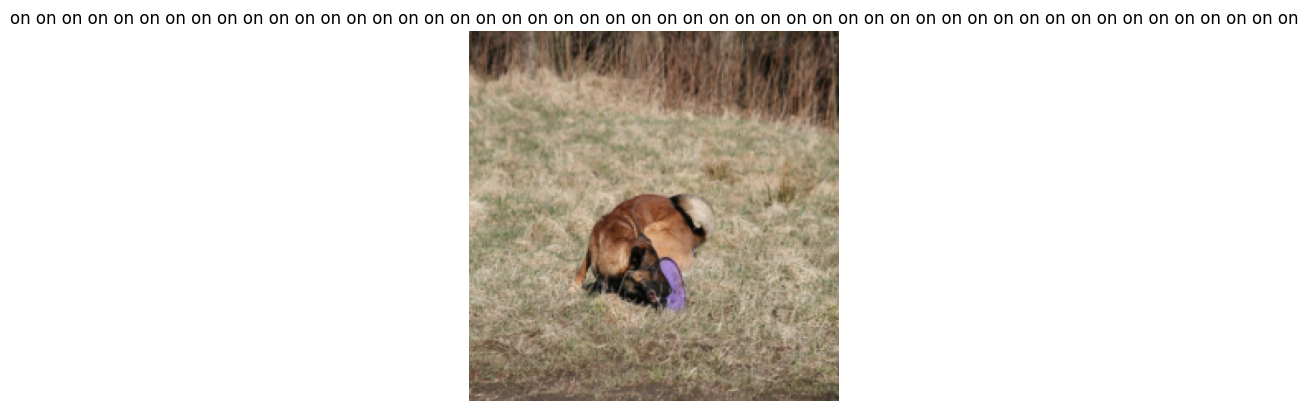

Epoch: 8, Average Training Loss: 2.4026561565549946
Validation Loss after epoch 9: 2.2378683015704155
Epoch: 8
Epoch 8 duration: 483.53 seconds
Epoch: 9, Batch: 100, Loss: 2.169372797012329
Generated caption: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


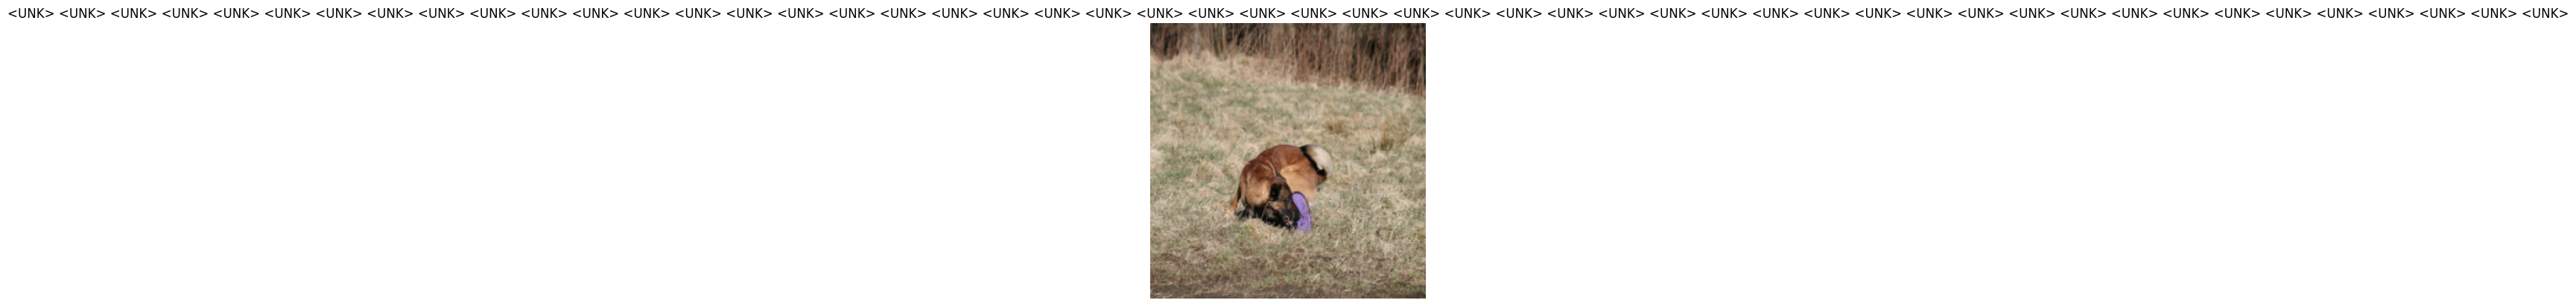

Epoch: 9, Batch: 200, Loss: 2.1319851875305176
Generated caption: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


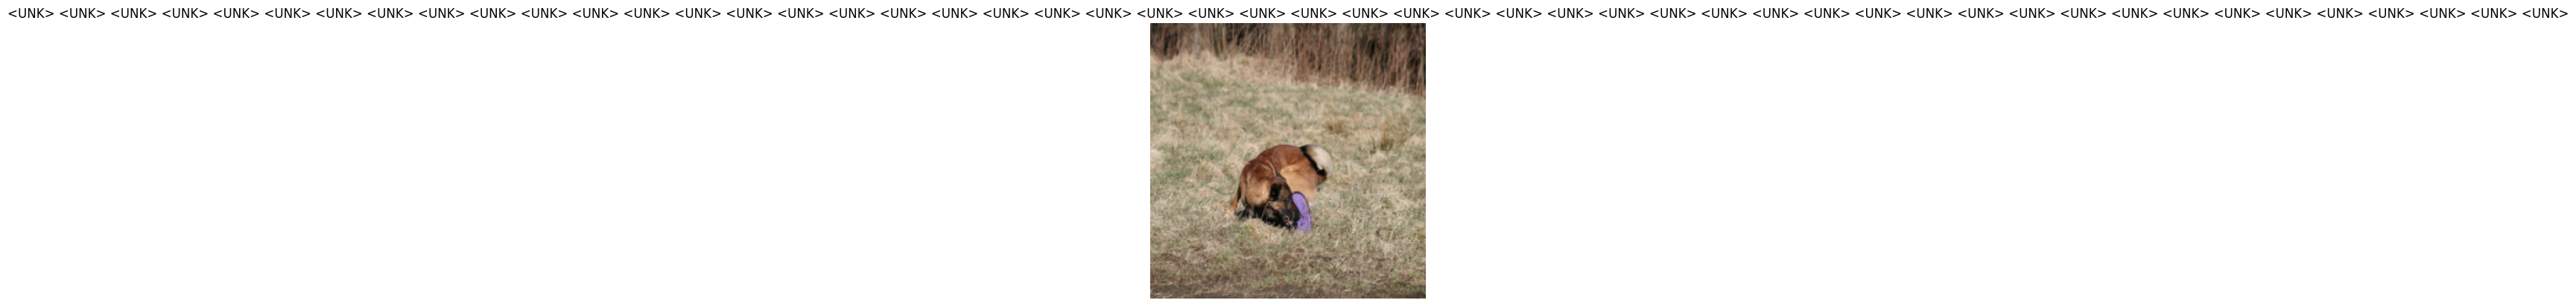

Epoch: 9, Average Training Loss: 2.2134799778225864
Validation Loss after epoch 10: 2.0657214168459177
Epoch: 9
Epoch 9 duration: 476.21 seconds
Epoch: 10, Batch: 100, Loss: 2.1316025257110596
Generated caption: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


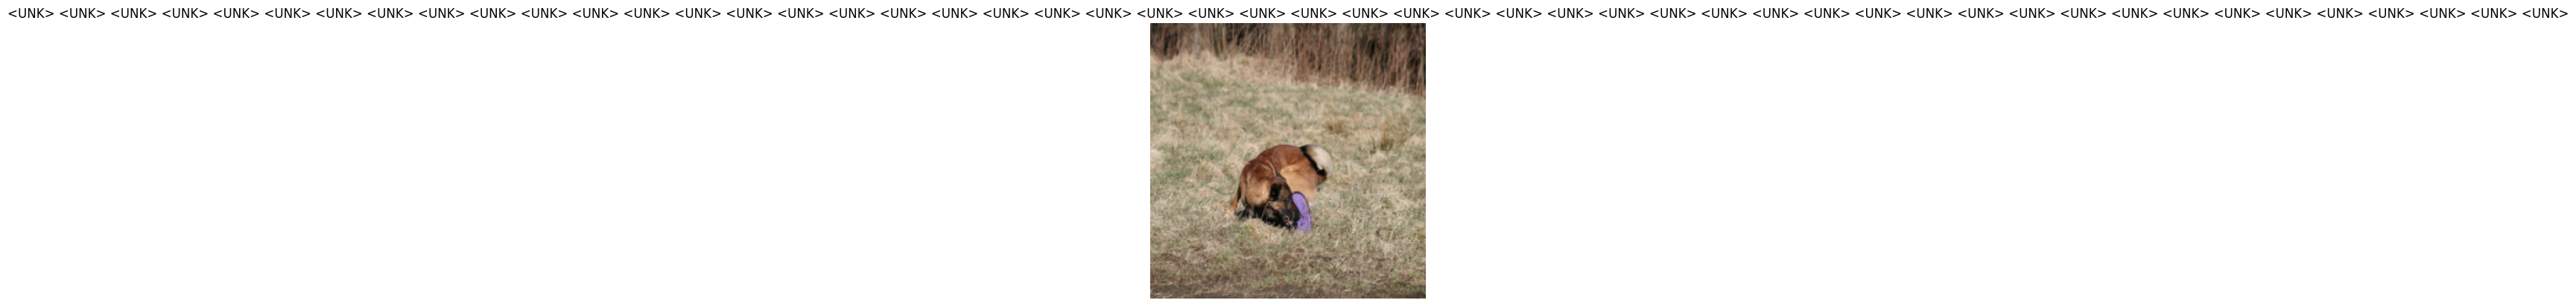

Epoch: 10, Batch: 200, Loss: 2.088679075241089
Generated caption: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


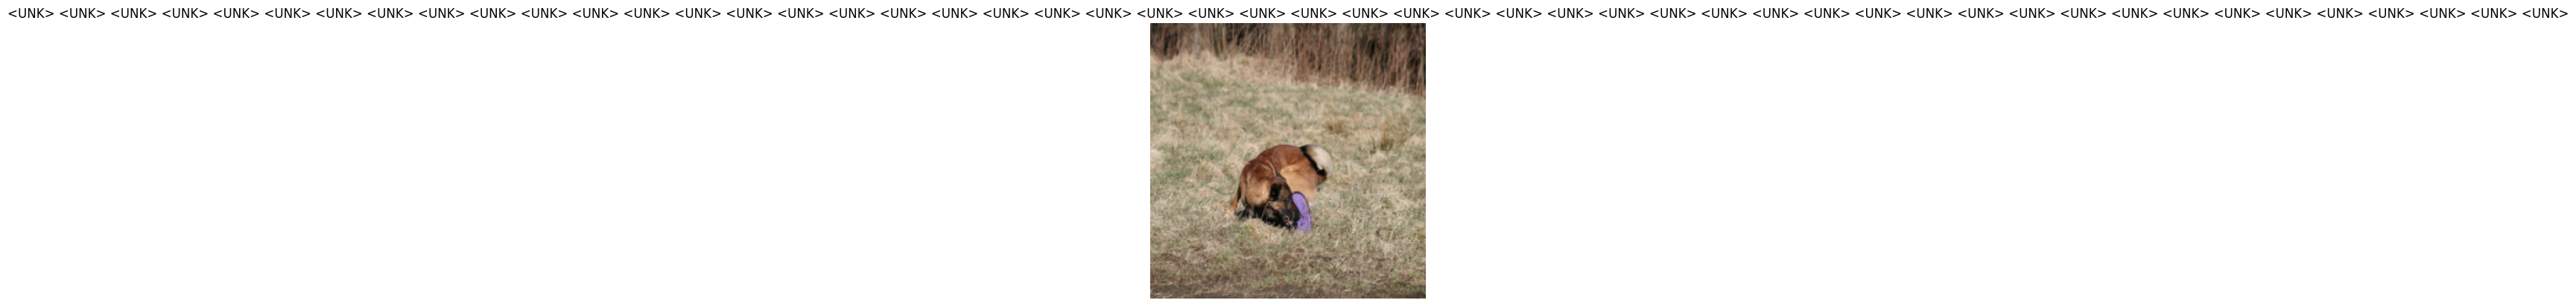

Epoch: 10, Average Training Loss: 2.046333037346248


In [ ]:
import matplotlib.pyplot as plt

# 이미지와 캡션을 시각화하는 함수
def show_image(image, title=None):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), 'checkpoint.pth')

# 학습 루프
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()  # 에폭 시작 시간 기록

    image_encoder.train()
    text_encoder.train()
    decoder.train()
    train_loss = 0.0

    for idx, (images, captions) in enumerate(train_loader):
        images, captions = images.to(device), captions.to(device)

        optimizer.zero_grad()

        image_features = image_encoder(images)
        text_features = text_encoder(captions)

        # Teacher Forcing
        output = decoder(image_features, text_features, captions[:, :-1])
        loss = criterion(output.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (idx + 1) % print_every == 0:
            print(f"Epoch: {epoch}, Batch: {idx + 1}, Loss: {loss.item()}")

            # 모델을 평가 모드로 전환
            image_encoder.eval()
            text_encoder.eval()
            decoder.eval()
            with torch.no_grad():
                dataiter = iter(test_loader)
                img, _ = next(dataiter)
                img = img.to(device)
                features = image_encoder(img)
                text_features_sample = text_encoder(torch.tensor([[vocab.stoi["<SOS>"]]]).to(device))
                caps = decoder.generate_caption(features, text_features_sample, vocab=vocab)
                caption = ' '.join(caps)
                print(f"Generated caption: {caption}")
                show_image(img.cpu()[0], title=caption)

            # 모델을 다시 학습 모드로 전환
            image_encoder.train()
            text_encoder.train()
            decoder.train()

    train_loss /= len(train_loader)
    print(f"Epoch: {epoch}, Average Training Loss: {train_loss}")

    # 검증 손실 계산
    image_encoder.eval()
    text_encoder.eval()
    decoder.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, captions in test_loader:
            images, captions = images.to(device), captions.to(device)
            image_features = image_encoder(images)
            text_features = text_encoder(captions)
            output = decoder(image_features, text_features, captions[:, :-1])

            loss = criterion(output.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f"Validation Loss after epoch {epoch + 1}: {val_loss}")
    print(f"Epoch: {epoch}")
    epoch_end_time = time.time()  # 에폭 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 에폭 소요 시간 계산
    print(f"Epoch {epoch} duration: {epoch_duration:.2f} seconds")

# 모델 저장
torch.save({
    'image_encoder_state_dict': image_encoder.state_dict(),
    'text_encoder_state_dict': text_encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
}, 'multimodal_transformer_final.pth')

In [ ]:
# CIDEr 점수 평가 함수 정의
from pycocoevalcap.cider.cider import Cider

def evaluate_cider(model, data_loader, dataset):
    image_encoder.eval()
    text_encoder.eval()
    decoder.eval()
    gts = {}
    res = {}
    with torch.no_grad():
        for i, (images, captions) in enumerate(data_loader):
            images = images.to(device)
            captions = captions.to(device)
            image_features = image_encoder(images)
            text_features = text_encoder(captions)

            outputs = decoder(image_features, text_features, captions)

            for j in range(images.size(0)):
                reference_caption = dataset.df.iloc[i * images.size(0) + j]["caption"]
                generated_caption = outputs[j].argmax(dim=1).tolist()

                gts[i * images.size(0) + j] = [reference_caption]
                res[i * images.size(0) + j] = [" ".join([dataset.vocab.itos[idx] for idx in generated_caption if idx not in {dataset.vocab.stoi["<PAD>"], dataset.vocab.stoi["<SOS>"], dataset.vocab.stoi["<EOS>"]}])]

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(gts, res)
    return cider_score

# CIDEr 점수 계산 및 출력
cider_score = evaluate_cider(model, test_loader, test_dataset)
print(f"CIDEr Score: {cider_score}")
